##Download and prepare datasets

Device: cuda:0
EuroSAT_RGB dataset found
train dataset found
5760
5760
26880


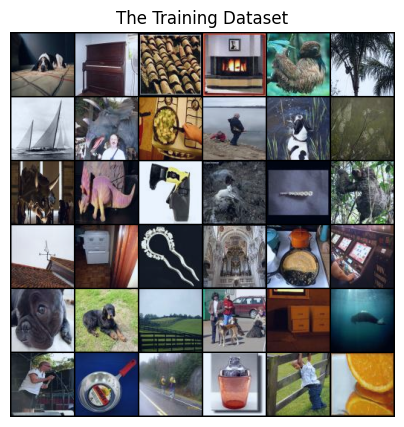

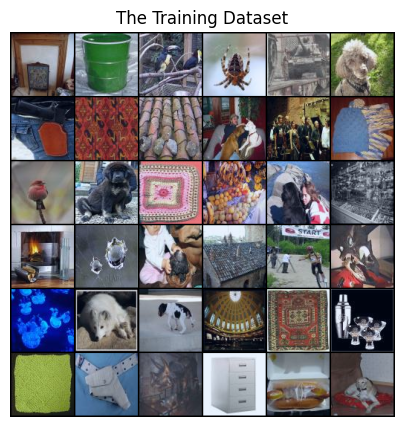

In [1]:

import argparse
import os
import random
import requests, zipfile, sys
import tarfile

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from PIL import Image

#enabe gpu if available with cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# check data exists
eurosat_path = "data/EuroSAT_RGB"
try: 
    if os.path.exists(eurosat_path):
        print("EuroSAT_RGB dataset found")
    elif os.path.exists(eurosat_path + ".zip"):
        print("train.tar dataset found, unzipping...")
        with zipfile.ZipFile(eurosat_path + ".zip", "r") as zf:
            print("Opened zipfile")
            zf.extractall("data/")
            print("EuroSAT_RGB.zip extracted")
except FileNotFoundError:
    print("The file data/EuroSAT_RGB was not found")

train_tar = "data/train"
try: 
    if os.path.exists(train_tar):
        print("train dataset found")
    elif os.path.exists(train_tar + ".tar"):
        print("train.tar dataset found, unzipping...")
        with tarfile.open(train_tar + ".tar", "r") as tf:
            print("Opened tarfile")
            tf.extractall(path="data/")
            print("train.tar extracted")
except FileNotFoundError:
    print("train data was not found")


#Download train.tar -file from miniImageNet datset
train_tar = "data/train"

# Image Size
tar_image_size = 84
eurosat_image_size = 64

# Load the dataset
transform = transforms.Compose([
    transforms.Resize((tar_image_size, tar_image_size)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(train_tar, transform=transform)

# Splitting the dataset into train, val, and test
data_len = len(dataset)
test = int(data_len  * 0.15)
valid = test
train = len(dataset) - test * 2
print(test)
print(valid)
print(train)


train_dataset, val_dataset, test_dataset = random_split(dataset, [train, valid, test])

# Batch size during training
batch_size = 128
num_workers = 1

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()

#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()



#

## Pretrain a model

In [2]:
from torchvision import models
import time
import torch.optim as optim

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, f)) for f in os.listdir(directory))

# Replace this with the path to your directory
directory_path = 'data/train'
folder_count = count_folders_in_directory(directory_path)

#print(f"There are {folder_count} folders in '{directory_path}'")

#model selection
model = models.resnet18(weights='IMAGENET1K_V1')
num_classes = folder_count
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Learning rate for optimizers
lr = 0.000012

# Number of training epochs
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# evaluation function
def evaluate_model(model, loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    model.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = model(images) 
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(model, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay (0.5 points)
    # your code here
    
    #optimizer =  optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    #give weight decay for last part
    
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
        
    #change epoches for last part to 20    
    for epoch in range(num_epochs):
        model.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            # TODO: rest of the training code
            # your code here, including the forward propagation (0.75 points), 
            # backward propagation (0.75 points) and calculating the accuracy (0.5 points)
            optimizer.zero_grad()
            #forward 
            outputs = model(images)
            loss = loss_function(outputs, labels)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += labels.size(0)
            
            #backward
            loss.backward()
            optimizer.step()
            
            #Add lr_scheduler.step() at the end of each epoch loop 
            #this is for the last part aswell
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
            
            #running_loss += loss.item()
        #average loss per image    
        #average_loss = running_loss / num_images
        
        acc = correct / num_images
        acc_eval = evaluate_model(model, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch+1, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return model


print('Please wait patiently, it may take some seconds...')
# TODO: train your network here (0.75 points)
# your code here
network = train(model, train_loader, val_loader)

# TODO: test your network here on
acc_test = evaluate_model(network, test_loader)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:


Please wait patiently, it may take some seconds...
epoch: 1, lr: 0.000012, accuracy: 0.162909, loss: 3.000455, valid accuracy: 0.352778


KeyboardInterrupt: 

##Fine-tuning with EuroSAT dataset

len selected images  100
one item looks like  ('data/EuroSAT_RGB\\SeaLake\\SeaLake_1688.jpg', 9)
class  9  amount  5
class  4  amount  5
class  6  amount  5
class  1  amount  5
class  2  amount  5
len train images  25
len test images  75


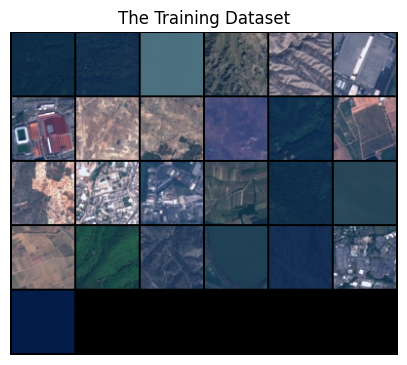

In [8]:
import random
import shutil

# Path to the .ipynb_checkpoints directory
ipynb_checkpoints_path = os.path.join(eurosat_path, '.ipynb_checkpoints')

# Check if .ipynb_checkpoints exists and remove it
if os.path.exists(ipynb_checkpoints_path):
    shutil.rmtree(ipynb_checkpoints_path)
    print(f"Removed {ipynb_checkpoints_path}")
    
#select data
eurosatdata = datasets.ImageFolder(root=eurosat_path, transform=transform)
#print(eurosatdata)

#makes dictrionary that maps indices back to class names.
idx_to_class = {v: k for k, v in eurosatdata.class_to_idx.items()}
#print(idx_to_class)



#select 100 images across 5 categories 20 images form each
def select_images(dataset, num_categories=5, images_per_category=20):
    categories = dataset.classes
    selected_categories = random.sample(categories, num_categories)
    selected_images = []

    for category in selected_categories:
        category_idx = dataset.class_to_idx[category]
        category_images = [image for image in dataset.imgs if image[1] == category_idx]
        selected_images.extend(random.sample(category_images, images_per_category))

    return selected_images

selected_images = select_images(eurosatdata)

#print(len(selected_images))
#print(selected_images[0])
#print(idx_to_class[selected_images[0][1]])



#split into training and test sets
def split_data(selected_images, num_categories=5, images_per_train_category=5):
    random.shuffle(selected_images)
    
    train_images = []
    test_images = []

    # Initialize a dictionary to count images per category in the training set
    category_count = {class_name: 0 for class_name in idx_to_class.values()}

    for img_path, class_idx in selected_images:
        class_name = idx_to_class[class_idx]
        if category_count[class_name] < images_per_train_category:
            train_images.append((img_path, class_idx))
            category_count[class_name] += 1
        else:
            test_images.append((img_path, class_idx))

    return train_images, test_images

train_images, test_images = split_data(selected_images)
#print(len(train_images))
#print(len(test_images))
#print(train_images)
#print(test_images)

transform = transforms.Compose([
    transforms.Resize((eurosat_image_size, eurosat_image_size)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#create custom datasets for pytorch dataloader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html example from
class CustomDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path, label = self.img_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset_eurosat = CustomDataset(train_images, transform=transform)
test_dataset_eurosat = CustomDataset(test_images, transform=transform)

train_loader_eurosat = DataLoader(train_dataset_eurosat, batch_size=25, shuffle=True)
test_loader_eurosat = DataLoader(test_dataset_eurosat, batch_size=25, shuffle=False)

print("len selected images ", len(selected_images))
print("one item looks like ", selected_images[0])
check_dict = {}
for i in range(len(train_images)):
    if train_images[i][1] in check_dict:
        check_dict[train_images[i][1]] += 1
    else:
        check_dict[train_images[i][1]] = 1
# class number and amount in train data
for i in check_dict:
    print("class ", i, " amount ", check_dict[i])

print("len train images ", len(train_images))
print("len test images ", len(test_images))

real_batch = next(iter(train_loader_eurosat))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:25], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()

#fine tune

#testing


##Model comparison and optimization

##Evaluation on additional dataset (bonus tasks)